In [1]:
from google.colab import drive
drive.mount('/content/drive')
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import copy
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Mounted at /content/drive
cpu


In [2]:
load_model = models.vgg19(weights="IMAGENET1K_V1")
print(load_model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [3]:
load_model(torch.randn(1,3,224,224)).shape

torch.Size([1, 1000])

In [4]:
from torchsummary import summary
print(load_model)
summary(load_model, input_size=(3,224,224), device='cpu')
load_model = load_model.to(DEVICE)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224,224)), # size는 (height,width)
    # transforms.CenterCrop(size=(224,224)), # size 는 (height, width)
    ])

In [6]:
with open("/content/drive/MyDrive/Colab Notebooks/data/imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read()) # dictionary로 바꿀 수 있게 eval 사용해서 str -> dict 로
print(idx2label)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

In [7]:
idx2label[3]

'tiger shark, Galeocerdo cuvieri'

<class 'numpy.ndarray'>
(434, 650, 3)
<class 'torch.Tensor'>
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


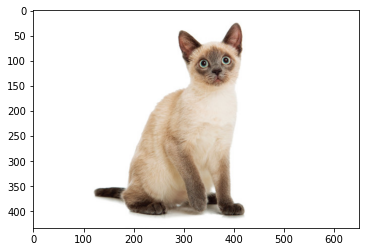

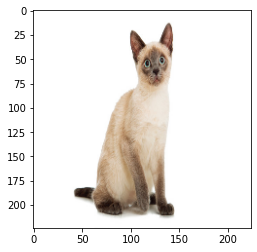

In [8]:
X=plt.imread("/content/drive/MyDrive/Colab Notebooks/data/my_image/2.jpg")
print(type(X))
print(X.shape)
plt.imshow(X)

X=transform(X)
print(type(X))
print(X.shape)
plt.figure()
plt.imshow(X.permute(1,2,0))

X = X.unsqueeze(dim=0).to(DEVICE)
print(X.shape)

In [9]:
load_model.eval()
with torch.no_grad():
    y_hat_sorted = load_model(X).sort(descending=True)
    # print(y_hat_sorted)
    percent_top5 = F.softmax(y_hat_sorted[0], dim=1)[0,:5]*100
    # print(percent_top5)
    pred_top5 = y_hat_sorted[1][0,:5] # sort 하고나서 [1]에 index가 담겨있음
    # print(pred_top5)
for i, idx in enumerate(pred_top5):
    print(idx2label[idx.item()],end="")
    print(f" ({round(percent_top5[i].item(),1)} %)")

Siamese cat, Siamese (85.8 %)
Egyptian cat (12.6 %)
lynx, catamount (0.5 %)
Arctic fox, white fox, Alopex lagopus (0.4 %)
weasel (0.1 %)


Text(0.5, 1.0, 'Siamese cat, Siamese')

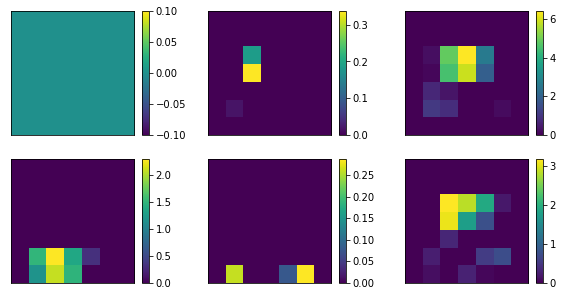

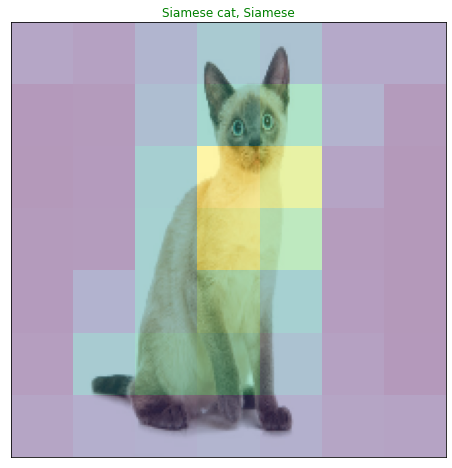

In [10]:
load_model.eval()
with torch.no_grad():
    X_feature = load_model.features(X)
    X_feature = load_model.avgpool(X_feature).cpu()

plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1, xticks=[], yticks=[])
    plt.imshow(X_feature[0,i,:,:])
    plt.colorbar()

summed_map = X_feature.sum(dim=1)
plt.figure(figsize=(8,8))
plt.xticks([]); plt.yticks([])
plt.imshow(X[0,...].cpu().permute(1,2,0))
plt.imshow(summed_map[0,...], extent=[0,224,224,0], alpha=0.4)
pred_class = idx2label[pred_top5[0].item()]
plt.title(pred_class, color="g")

In [11]:
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained("efficientnet-b7", num_classes=4).to(DEVICE)